# Combined network: 

- PV-Pyr unit --> Local network with self-supervised learning 

- SST-Pyr unit --> Global network with supervised learning


TODO:
- find this SST input ?

- Quantify learning: ablation of specific inputs or total specific areas
- Drop off of some units in specific areas or layers for example

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from skimage.metrics import structural_similarity as ssim
import numpy as np

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [70]:
from modules.network import PV_SST_Pyr

model = PV_SST_Pyr(thal_input_dim=784, SST_input_dim=784, latent_dim=10, output_dim=10)

print(model)

PV_SST_Pyr(
  (PV): PV(
    (Thal2PV): Thal2PV(
      (flatten): Flatten()
      (activation): Sigmoid()
      (fc1): Linear(in_features=784, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (fc3): Linear(in_features=64, out_features=10, bias=True)
    )
    (PV2Pyr): PV2Pyr(
      (activation): Sigmoid()
      (fc1): Linear(in_features=10, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=784, bias=True)
    )
  )
  (SST): SST(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
    (flatten): Flatten()
    (activation): Sigmoid()
  )
)


In [71]:
for name, param in model.named_parameters():
    print (name)   

PV.Thal2PV.fc1.weight
PV.Thal2PV.fc1.bias
PV.Thal2PV.fc2.weight
PV.Thal2PV.fc2.bias
PV.Thal2PV.fc3.weight
PV.Thal2PV.fc3.bias
PV.PV2Pyr.fc1.weight
PV.PV2Pyr.fc1.bias
PV.PV2Pyr.fc2.weight
PV.PV2Pyr.fc2.bias
PV.PV2Pyr.fc3.weight
PV.PV2Pyr.fc3.bias
SST.fc1.weight
SST.fc1.bias
SST.fc2.weight
SST.fc2.bias
SST.fc3.weight
SST.fc3.bias


### Train & test

In [72]:
lr = 0.05
momentum = 0.5
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 30
log_interval = 300
alpha = 0.5

train_losses = []
train_recon_losses = []
train_global_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader, model, optimizer, loss_fn, alpha =1):
    recon_loss_avg = 0
    global_loss_avg = 0
    loss_avg = 0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        thal_input, _ = batch
        SST_input, target = batch  
        t = F.one_hot(target, num_classes=10).float()
        _, decoded, output = model(thal_input, SST_input)

        recon_loss = loss_fn(decoded, thal_input.view(thal_input.size(0), -1)) 
        global_loss = loss_fn(output, t)
        total_loss = alpha*recon_loss + (1 - alpha)*global_loss
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(epoch, recon_loss_avg, global_loss_avg, loss_avg))

def test(dataloader, model, loss_fn):
    model.eval()
    recon_loss_avg = 0
    global_loss_avg = 0
    test_loss_avg = 0
    with torch.no_grad():
        for batch in dataloader:
            thal_input, _ = batch
            SST_input, target = batch  
            t = F.one_hot(target, num_classes=10).float()
            _, decoded, output = model(thal_input, SST_input)

            recon_loss = loss_fn(decoded, thal_input.view(thal_input.size(0), -1))
            global_loss = loss_fn(output, t)
            total_loss = alpha*recon_loss + (1 - alpha)*global_loss
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            #ssim_score = calculate_ssim(recon, inputs)
            
    recon_loss_avg, global_loss_avg, test_loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, global_loss_avg, test_loss_avg))
    test_losses.append(test_loss_avg)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f} Total loss: {:.6f}\n'.format(recon_loss_avg, global_loss_avg, test_loss_avg))
    


In [73]:
test(test_data_loader, model, loss_fn)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
  test(test_data_loader, model, loss_fn)

Test set: Recon_loss: 1.259558 Global_loss: 0.274627 Total loss: 0.767093

Epoch: 1 Recon_loss: 1.127347 Global_loss: 0.085781  Total loss: 0.606564
Test set: Recon_loss: 1.028989 Global_loss: 0.079439 Total loss: 0.554214

Epoch: 2 Recon_loss: 0.953873 Global_loss: 0.073665  Total loss: 0.513769
Test set: Recon_loss: 0.910239 Global_loss: 0.067314 Total loss: 0.488777

Epoch: 3 Recon_loss: 0.878029 Global_loss: 0.062837  Total loss: 0.470433
Test set: Recon_loss: 0.864171 Global_loss: 0.058093 Total loss: 0.461132

Epoch: 4 Recon_loss: 0.847833 Global_loss: 0.055130  Total loss: 0.451482
Test set: Recon_loss: 0.844146 Global_loss: 0.051902 Total loss: 0.448024

Epoch: 5 Recon_loss: 0.833741 Global_loss: 0.050149  Total loss: 0.441945
Test set: Recon_loss: 0.833761 Global_loss: 0.047914 Total loss: 0.440837

Epoch: 6 Recon_loss: 0.825933 Global_loss: 0.046922  Total loss: 0.436428
Test set: Recon_loss: 0.827605 Global_loss: 0.045142 Total loss: 0.436374

Epoch: 7 Recon_loss: 0.821128 G

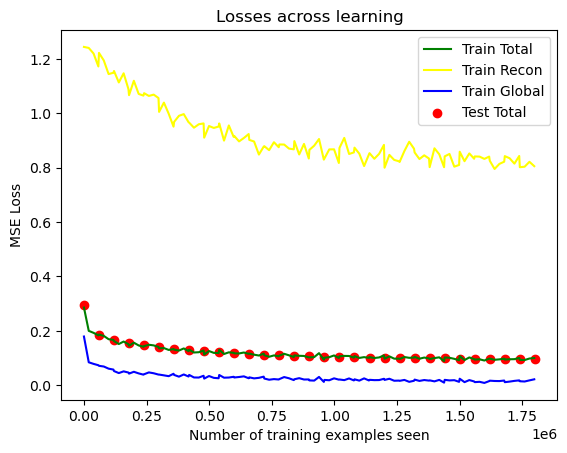

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green')
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train Global','Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Losses across learning")
plt.show()

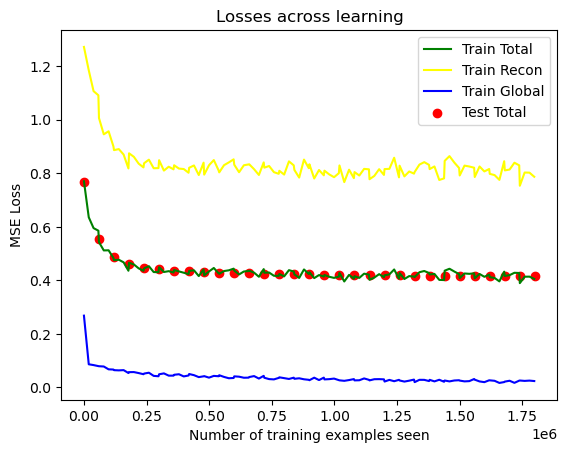

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green')
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train Global','Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Losses across learning")
plt.show()